In [1]:
import torch
import numpy as np
from Packages.RegistrationFunc import *
from Packages.SplitEbinMetric import *
from Packages.GeoPlot import *
import scipy.io as sio
import matplotlib.pyplot as plt
import SimpleITK as sitk

### Import data

In [2]:
index0, index1 = 1, 2
g00 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{index0}_scaled_tensors.nhdr'))).double()
g11 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{index1}_scaled_tensors.nhdr'))).double()

height, width = g00.shape[:2]
g0, g1 = torch.zeros(height, width, 2, 2, dtype=torch.double), torch.zeros(height, width, 2, 2, dtype=torch.double)
g0[:,:,0, 0] = g00[:,:,0]
g0[:,:,0, 1] = g00[:,:,1]
g0[:,:,1, 0] = g00[:,:,1]
g0[:,:,1, 1] = g00[:,:,2]
g1[:,:,0, 0] = g11[:,:,0]
g1[:,:,0, 1] = g11[:,:,1]
g1[:,:,1, 0] = g11[:,:,1]
g1[:,:,1, 1] = g11[:,:,2]

# g0 = torch.inverse(g0)
# g0mask = torch.where(torch.det(g0)>1e7, 1e-2/torch.det(g0), 5e-1)
# g1 = torch.inverse(g1)
# g1mask = torch.where(torch.det(g1)>1e7, 1e-2/torch.det(g1), 5e-1)

# g0 = torch.einsum('ij...,kij->ij...', g0, g0mask.unsqueeze(0))
# g1 = torch.einsum('ij...,kij->ij...', g1, g1mask.unsqueeze(0))

### Calculate geodesic

In [3]:
Tpts = 7
geo_group = get_geo(g0, g1, 0.5, Tpts)

/home/sci/hdai/Projects/Atlas2D/Packages/SplitEbinMetric.py:197: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  Ind_inRange = (theta < 0).nonzero().reshape(-1)


### Plot geodesic

In [4]:
def show_2d_tensors(nda0, scale=0.5, title=None, margin=0.05, dpi=80):
    
    nda = torch.zeros(*nda0.shape[-2:], 3, dtype=torch.double)
    nda[:,:,0] = nda0[0,0,:,:]
    nda[:,:,1] = nda0[0,1,:,:]
    nda[:,:,2] = nda0[1,1,:,:]
    nda = nda.numpy()
    
    if nda.ndim == 3:
      # fastest dim, either component or x
      c = nda.shape[-1]       
      # the number of component is 3 consider it a tensor image
      if c != 3:
        raise Runtime("Unable to show 3D-vector Image")

    xsize = nda.shape[0]
    ysize = nda.shape[1]

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    if xsize > dpi and ysize > dpi:
        figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    else:
        figsize = (1 + margin) * dpi / ysize, (1 + margin) * dpi / xsize
        
    fig = plt.figure(figsize=figsize)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    tens = np.zeros((2,2))
    triu_idx = np.triu_indices(2)
    ellipses = []
#     xax = [1,0]
    for x in range(xsize):
        for y in range(ysize):
            tens[triu_idx] = nda[x,y]
            tens[1,0] = tens[0,1]
            evals, evecs = np.linalg.eigh(tens)
            angle = np.degrees(np.math.atan2(evecs[1][0],evecs[1][1]))
            ellipses.append(Ellipse((y,x), width=scale * evals[1], height = scale * evals[0], angle=angle))
    collection = PatchCollection(ellipses, alpha=0.7,color='k')
    ax.add_collection(collection)
    ax.set_xlim(0,ysize)
    ax.set_ylim(0,xsize)
    ax.set_aspect('equal')
    plt.axis('off')
    
#     if(title):
#         plt.title(title)
    plt.savefig(title, bbox_inches='tight')
    

def GetSITKImageFromNP(npimg, has_component_data=False):
  # If RGB or tensor data etc, set has_component_data to True so that last dimension is not
  # transposed.
  # This assumes that the component data is in the last dimension.
  # TODO fix this assumption to work for component data in first dimension as well
  # Currently works for 2D and 3D images
  if has_component_data:
    transpose_tuple=(1,0,2)
    if len(npimg.shape) == 4:
      transpose_tuple=(2,1,0,3)    
    return sitk.GetImageFromArray(np.transpose(npimg,transpose_tuple))
  else:
    transpose_tuple=(1,0)
    if len(npimg.shape) == 3:
      transpose_tuple=(2,1,0)           
    return sitk.GetImageFromArray(np.transpose(npimg, transpose_tuple))

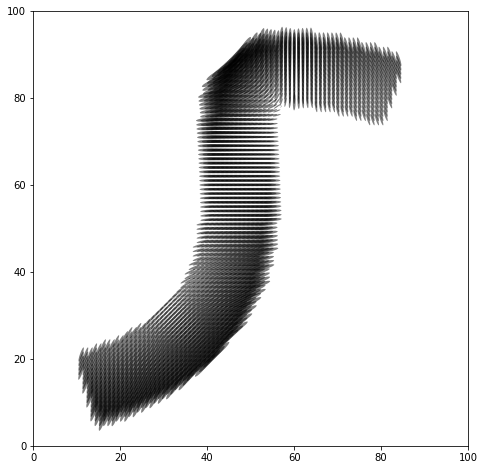

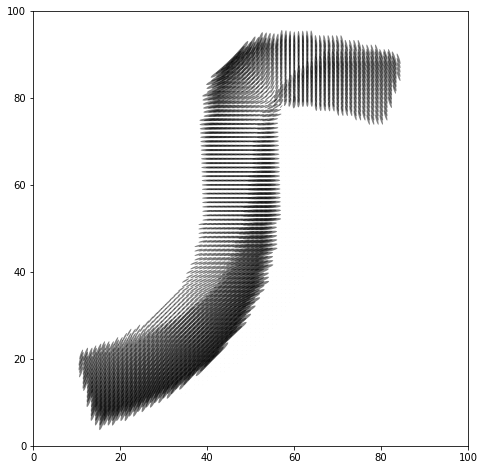

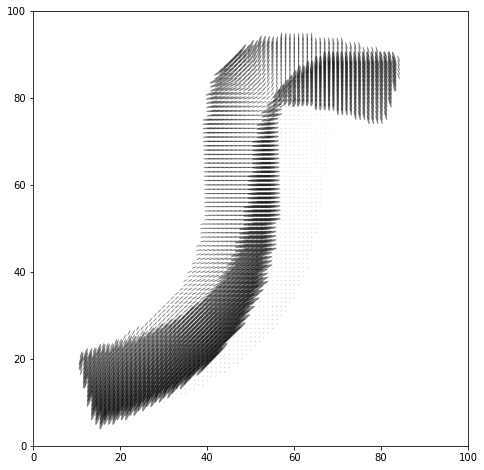

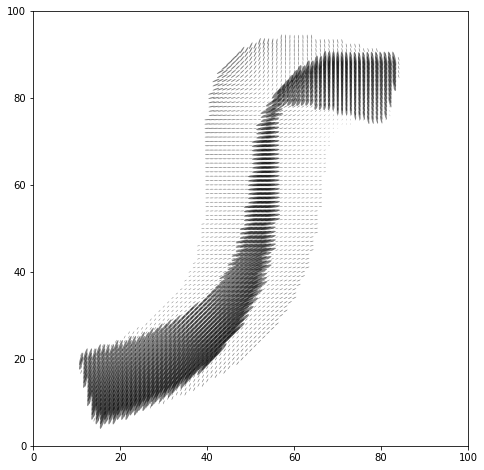

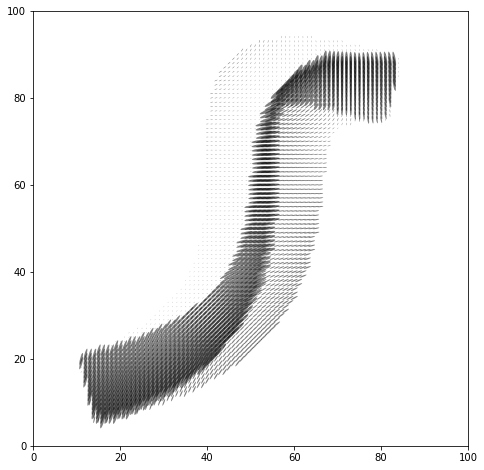

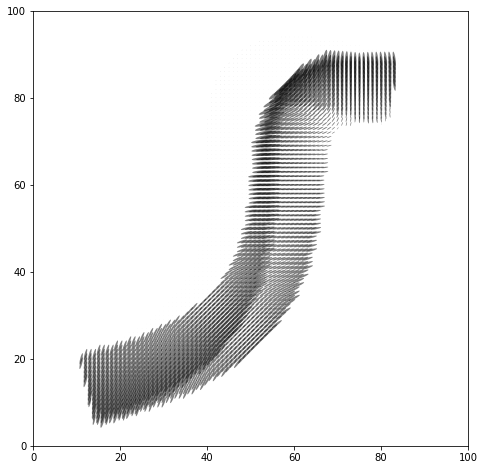

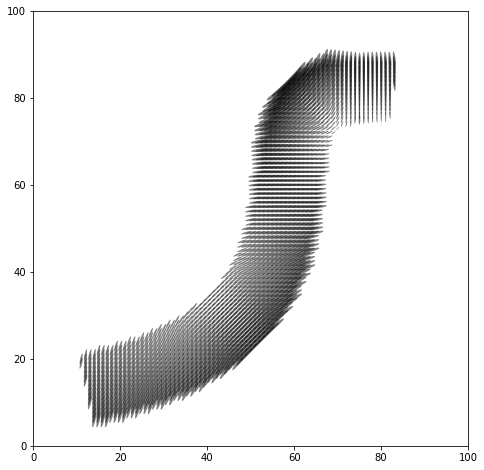

In [8]:
geoi = np.zeros((height,width,3))
for i in range(Tpts):
#     show_2d_tensors(geo_group[i].permute(2,3,0,1), scale=1e-3, title=f'Output/cubic_12_geodesic_{Tpts}/cubic_12_geodesic_{i}.pdf', margin=0.05, dpi=20)
#     print(geo_group[i].shape)
    geoi[:,:,0]=geo_group[i][:,:,0,0]
    geoi[:,:,1]=geo_group[i][:,:,0,1]
    geoi[:,:,2]=geo_group[i][:,:,1,1]
    vis_tensors_kris(geoi.transpose(2,1,1), title='', save_file=False, filename='', mask=None,scale=5e-1,opacity=0.5, show_axis_labels=True, ax=None,zorder=1,stride=None)
    sitk.WriteImage(GetSITKImageFromNP(geoi, has_component_data=True), f'Output/cubic_12_geodesic_{Tpts}/cubic_12_geodesic_{i}.nhdr')

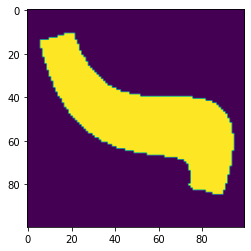

(100, 100)


In [6]:
mask00 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{index0}_filt_mask.nhdr'))).double()
mask11 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{index1}_filt_mask.nhdr'))).double()
mask = mask00+mask11
mask_bin = np.zeros_like(mask)
mask_bin[mask>0] = 1
plt.imshow(mask_bin)
plt.show()
print(mask_bin.shape)
sitk.WriteImage(GetSITKImageFromNP(mask_bin, has_component_data=False), f'Output/cubic_12_geodesic_{7}/cubic_12_filt_mask.nhdr')